In [ ]:
!nvidia-smi

Wed Dec 23 03:59:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |  14717MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import re
import random
import time
import datetime
import numpy as np      
import pandas as pd       
import matplotlib.pyplot as plt   
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import gc
from sklearn.metrics import accuracy_score

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
pd.options.display.max_colwidth = None
pd.options.display.max_rows = 100

We will use the GPU: Tesla T4


In [ ]:
train = pd.read_csv("/content/drive/My Drive/dacon/news_train.csv") # train.csv 불러오기
test = pd.read_csv("/content/drive/My Drive/dacon/news_test.csv") # test.csv 불러오기
train["id"] = train["n_id"].astype(str) + '_' + train["ord"].astype(str)
train.drop(['n_id', 'ord'],axis = 1) 
train['length'] = train['content'].apply(lambda x: len(x))
print(test.shape)
print(train.shape)


(142565, 6)
(118745, 8)


In [ ]:
def preprocess(text):
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #remove some puncts (except . ! ?)
    text=re.sub(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '',text)
    text=" ".join(text.split())
    return text

train['clean_text'] = train['content'].apply(preprocess)
test['clean_text'] = test['content'].apply(preprocess)
train['clean_title'] = train['title'].apply(preprocess)
test['clean_title'] = test['title'].apply(preprocess)

test.head(2)

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=50, evaluator=evaluator2)

In [ ]:
from transformers import XLMTokenizer, XLMModel, XLMForSequenceClassification

tokenizer = XLMTokenizer.from_pretrained("xlm-mlm-17-1280")
model = XLMForSequenceClassification.from_pretrained("xlm-mlm-17-1280",num_labels=2)
model.cuda()

Some weights of the model checkpoint at xlm-mlm-17-1280 were not used when initializing XLMForSequenceClassification: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing XLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMForSequenceClassification were not initialized from the model checkpoint at xlm-mlm-17-1280 and are newly initialized: ['transformer.position_ids', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

XLMForSequenceClassification(
  (transformer): XLMModel(
    (position_embeddings): Embedding(512, 1280)
    (embeddings): Embedding(200000, 1280, padding_idx=2)
    (layer_norm_emb): LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0): MultiHeadAttention(
        (q_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (k_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (v_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (out_lin): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (1): MultiHeadAttention(
        (q_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (k_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (v_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (out_lin): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (2): MultiHeadAttention(
        (q_lin): Linear(in_features=1280, 

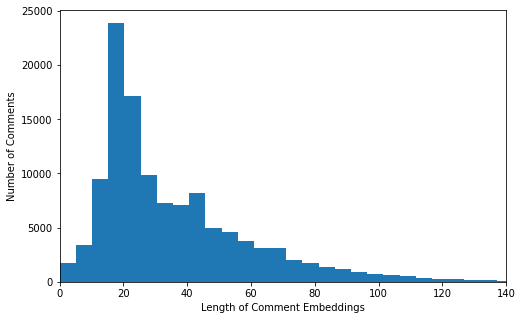

In [ ]:
texts = train['clean_text'].values
labels = train['info'].values

def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    plt.xlim(0, 140)
    return
plot_sentence_embeddings_length(texts, tokenizer)


In [ ]:
%time
indices=tokenizer.batch_encode_plus(texts,max_length=120,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

# Use 99% for training and 1% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.1)
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

optimizer = AdamW(model.parameters(),lr = 6e-6, eps = 1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()

    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)  #   [0]: input ids 
        b_input_mask = batch[1].to(device) #   [1]: attention masks
        b_labels = batch[2].to(device)     #   [2]: labels 
        model.zero_grad() # Always clear any previously calculated gradients before performing a backward pass using pytorch    
        # Perform a forward pass (evaluate the model on this training batch). This will return the loss
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)        
        loss = outputs[0] # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        total_loss += loss.item()  # Accumulate the training loss over all of the batches for calculate the average loss at the end
        loss.backward() # Perform a backward pass to calculate the gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip the norm of the gradients to 1.0. to help prevent the "exploding gradients" problem.
        optimizer.step() # Update parameters and take a step using the computed gradient.
        scheduler.step() # Update the learning rate.
    avg_train_loss = total_loss / len(train_dataloader) # Calculate the average loss over the training data.            
    loss_values.append(avg_train_loss) # Store the loss value for plotting the learning curve.

    print("\n  Average training loss: {0:.2f}".format(avg_train_loss), "  Training epoch took: {:}\n".format(format_time(time.time() - t0)))
print("Training complete!")



======== Epoch 1 / 3 ========
Training...
  Batch    50  of  6,674.    Elapsed: 0:01:00.
  Batch   100  of  6,674.    Elapsed: 0:02:03.
  Batch   150  of  6,674.    Elapsed: 0:03:07.
  Batch   200  of  6,674.    Elapsed: 0:04:11.
  Batch   250  of  6,674.    Elapsed: 0:05:16.
  Batch   300  of  6,674.    Elapsed: 0:06:22.
  Batch   350  of  6,674.    Elapsed: 0:07:28.
  Batch   400  of  6,674.    Elapsed: 0:08:34.
  Batch   450  of  6,674.    Elapsed: 0:09:39.
  Batch   500  of  6,674.    Elapsed: 0:10:45.
  Batch   550  of  6,674.    Elapsed: 0:11:51.
  Batch   600  of  6,674.    Elapsed: 0:12:57.
  Batch   650  of  6,674.    Elapsed: 0:14:03.
  Batch   700  of  6,674.    Elapsed: 0:15:09.
  Batch   750  of  6,674.    Elapsed: 0:16:15.
  Batch   800  of  6,674.    Elapsed: 0:17:20.
  Batch   850  of  6,674.    Elapsed: 0:18:26.
  Batch   900  of  6,674.    Elapsed: 0:19:32.
  Batch   950  of  6,674.    Elapsed: 0:20:38.
  Batch 1,000  of  6,674.    Elapsed: 0:21:44.
  Batch 1,050  of

In [ ]:
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
print("\nRunning Validation...")
t0 = time.time()
model.eval() # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
preds=[]
true=[]
# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch) # Add batch to GPU
    b_input_ids, b_input_mask, b_labels = batch # Unpack the inputs from our dataloader
    with torch.no_grad(): # Telling the model not to compute or store gradients, saving memory and speeding up validation      
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask) # Forward pass, calculate logit predictions, cuz not with labels
    
    logits = outputs[0] # values prior to applying an activation function like the softmax.
    logits = logits.detach().cpu().numpy() # Move logits and labels to CPU
    label_ids = b_labels.to('cpu').numpy() # Move logits and labels to CPU
    preds.append(logits)
    true.append(label_ids)
    
    tmp_eval_accuracy = flat_accuracy(logits, label_ids) # Calculate the accuracy for this batch of test sentences.
    eval_accuracy += tmp_eval_accuracy # Accumulate the total accuracy
    nb_eval_steps += 1 # Track the number of batches

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}\n".format(format_time(time.time() - t0)))
print("  Classification report\n",classification_report(flat_predictions,flat_true_labels))
print("  Model saving....")

torch.save(model, '/content/drive/My Drive/dacon/xlm_1280.pt')  


Running Validation...
  Accuracy: 0.99
  Validation took: 0:05:14

  Classification report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7151
           1       0.98      0.99      0.98      4713

    accuracy                           0.99     11864
   macro avg       0.99      0.99      0.99     11864
weighted avg       0.99      0.99      0.99     11864

  Model saving....


In [ ]:
comments1 = test['clean_text'].values

indices1=tokenizer.batch_encode_plus(comments1,max_length=120,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

model.eval()
predictions = []
for batch in prediction_dataloader1:
  batch = tuple(t.to(device) for t in batch) # Add batch to GPU
  b_input_ids1, b_input_mask1 = batch # Unpack the inputs from our dataloader
  with torch.no_grad(): # Telling the model not to compute or store gradients, saving memory and speeding up prediction 
      outputs1 = model(b_input_ids1, token_type_ids=None, attention_mask=b_input_mask1) # Forward pass, calculate logit predictions
  logits1 = outputs1[0]
  logits1 = logits1.detach().cpu().numpy() # Move logits and labels to CPU
  predictions.append(logits1) # Store predictions and true labels

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

sample_sub=pd.read_csv('/content/drive/My Drive/dacon/sample_submission.csv')
submit=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'info':flat_predictions})
submit.to_csv('/content/drive/My Drive/dacon/xlm_1280.csv',index=False)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 142,565 test sentences...
